# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from workspace_utils import active_session
import re
import itertools
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

**Note:**

The analysis will begin by getting a general idea of the structure and data in the `AZDIAS_Feature_Summary.csv` file. Then the structure and data in the `Udacity_AZDIAS_Subset.csv` will be analyzed. 

In [189]:
print('The summary of features dataset has {} rows and {} columns.'.format(feat_info.shape[0], feat_info.shape[1]))
feat_info.head(10)

The summary of features dataset has 85 rows and 4 columns.


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1.0, 0.0, 9.0]"
2,ANREDE_KZ,person,categorical,"[-1.0, 0.0]"
3,CJT_GESAMTTYP,person,categorical,[0.0]
4,FINANZ_MINIMALIST,person,ordinal,[-1.0]
5,FINANZ_SPARER,person,ordinal,[-1.0]
6,FINANZ_VORSORGER,person,ordinal,[-1.0]
7,FINANZ_ANLEGER,person,ordinal,[-1.0]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1.0]
9,FINANZ_HAUSBAUER,person,ordinal,[-1.0]


In [4]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [5]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,GEBAEUDETYP_RASTER,person,ordinal,[-1]
freq,1,43,49,26


In [6]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [7]:
print('The AZDIAS dataset has {} rows and {} columns.'.format(azdias.shape[0], azdias.shape[1]))
azdias.head()

The AZDIAS dataset has 891221 rows and 85 columns.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [9]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [10]:
azdias.shape

(891221, 85)

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
#Create copy of dataset to clean it
feat_info_clean = feat_info.copy(deep = True)
azdias_clean = azdias.copy(deep = True)

In [12]:
natural_missing_values = (azdias_clean.isnull().sum()/azdias_clean.shape[0]*100).sort_values(ascending = False)

In [13]:
natural_missing_values[:5]

KK_KUNDENTYP    65.596749
KBA05_ANTG1     14.959701
KBA05_ANTG2     14.959701
KBA05_ANTG3     14.959701
KBA05_ANTG4     14.959701
dtype: float64

In [14]:
(natural_missing_values> 10).sum()

35

**Note:**

To assess what missing or unknow values have to be replaced by `np.nan` values following steps will be taken:

1. Eliminate unnecessary characters from `missing_or_unknown` column of `feat_info_clean`
2. Split characters to a list
3. Convert characters to floats
4. Use floats to replace values in `azdias_clean` dataframe

In [15]:
def eliminate_characters(data_column, characters):
    '''This function aims to eliminate a set of characters from a specific column in a datest
    INPUT: 
        1. Data column in which the characters should be eliminated
        2. Character or list of characters that should be eliminated from data column
    OUTPUT:
        1. None
        '''
    data_column.replace(to_replace = characters, value = '', regex = True, inplace = True)

In [16]:
characters = ['\[', '\]']

eliminate_characters(feat_info_clean.missing_or_unknown, characters)

In [17]:
feat_info_clean.head(3)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"-1,0"
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9"
2,ANREDE_KZ,person,categorical,"-1,0"


In [18]:
feat_info_clean.missing_or_unknown = feat_info_clean.missing_or_unknown.str.split(',')

In [19]:
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [20]:
unknown_missing_values_list = feat_info_clean.missing_or_unknown.tolist()

In [21]:
def convert_to_float(values_list):
    '''This function takes as input a nested list (2 levels) and converts all numerical values to floats in place while
    ignoring strings or empty strings.
    INPUT: List of values to be transformed
    OUTPUT: None
    '''
    for i in range(len(values_list)):
        for j in range(len(values_list[i])):
            if re.search(r'[A-Z]+', values_list[i][j]) or re.search(r'^$', values_list[i][j]):
                pass
            else:
                values_list[i][j] = float(values_list[i][j])

In [22]:
convert_to_float(unknown_missing_values_list)

In [23]:
unknown_missing_values_list[:15]

[[-1.0, 0.0],
 [-1.0, 0.0, 9.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0]]

**NOTE:**

There are multiple values in the `unknown_missing_values_list` that are empty strings. In the next steps, the columns that should have empty strings encoded as `np.nan` values will be investigated to make sure that conversion of unknown and missing values to `np.nan` values runs smoothly. 

In [24]:
empty_strings = []
for i in range(len(unknown_missing_values_list)):
    for item in unknown_missing_values_list[i]:
        if item == '':
            empty_strings.append(i)
empty_strings

[12, 13, 44, 45, 51, 53, 69, 71, 72, 74]

In [25]:
column_names = azdias_clean.columns
columns_to_check = []
for value in empty_strings:
    columns_to_check.append(column_names[value])
    
columns_to_check

['GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'GEBAEUDETYP_RASTER',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'KBA13_ANZAHL_PKW']

In [26]:
for column in columns_to_check:
    print('Unique values in column {}: {}'.format(column, azdias_clean[column].unique()))

Unique values in column GFK_URLAUBERTYP: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Unique values in column GREEN_AVANTGARDE: [0 1]
Unique values in column ANZ_PERSONEN: [ nan   2.   1.   0.   4.   3.   5.   7.   6.   8.  12.   9.  21.  10.  13.
  11.  14.  45.  20.  31.  29.  37.  16.  22.  15.  23.  18.  35.  17.  40.
  38.]
Unique values in column ANZ_TITEL: [ nan   0.   1.   2.   4.   3.   6.]
Unique values in column ANZ_HH_TITEL: [ nan   0.   1.   5.   2.   3.   7.   4.   6.   9.  15.  14.   8.  11.  10.
  12.  13.  20.  16.  17.  23.  18.]
Unique values in column KONSUMNAEHE: [ nan   1.   5.   4.   3.   2.   6.   7.]
Unique values in column GEBAEUDETYP_RASTER: [ nan   3.   4.   5.   1.   2.]
Unique values in column MOBI_REGIO: [ nan   1.   3.   4.   5.   2.   6.]
Unique values in column ONLINE_AFFINITAET: [  1.   3.   2.   5.   4.   0.  nan]
Unique values in column KBA13_ANZAHL_PKW: [  nan  963.  712. ...,    2.   30.    7.]


**Note:**

It looks as if the columns that should have empty strings do not have any. Therefore in the `replace_by_nan` function all missing or unknown values encoded as an empty string will be ignored.

In [27]:
def replace_by_nan(missing_values_list, column_referece_list):
    ''' This function replaces all values encoded in the missing_values_list by np.nan values
    INPUT: 
        1. List encoding all values that should be replaced by np.nan values
        2. List of columns on which the values should be replaced by np.nan values
    OUTPUT:
        2. Dictionary containig the column name and the values that should be replaced mapped to np.nan values.
        This dict can be used with the pd.DataFrame.replace() function to replace the desired values
        '''
    replace_values = {}
    for idx, i in enumerate(missing_values_list):
        temp_dict = {}
        for j in i:
            if j != '':
                temp_dict[j] = np.nan
                replace_values[column_referece_list[idx]] = temp_dict
    return replace_values

In [28]:
azdias_clean = azdias_clean.replace(replace_by_nan(unknown_missing_values_list, column_names))

In [29]:
#Test to see if the required values have been replaced
azdias_clean[azdias_clean['ALTERSKATEGORIE_GROB'] == 9.0]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [30]:
(azdias_clean.isnull().sum().sum() - azdias.isnull().sum().sum())/azdias.isnull().sum().sum() 

0.71006861979097535

In [31]:
missing_before = pd.DataFrame(azdias.isnull().sum(), columns = ['Missing_before_clean'])
missing_after = pd.DataFrame(azdias_clean.isnull().sum(), columns = ['Missing_after_clean'])


In [32]:
comp_missing = pd.merge(missing_before, missing_after,
                        left_index = True, right_index = True) 

In [33]:
comp_missing.sort_values(by = ['Missing_before_clean'],
                         ascending = True)[:15]

,Missing_before_clean,Missing_after_clean
AGER_TYP,0,685843
SEMIO_SOZ,0,0
SEMIO_FAM,0,0
SEMIO_REL,0,0
SEMIO_MAT,0,0
SEMIO_VERT,0,0
SEMIO_LUST,0,0
SEMIO_ERL,0,0
PRAEGENDE_JUGENDJAHRE,0,108164
SEMIO_KULT,0,0


In [34]:
comp_missing['Diff'] = comp_missing['Missing_before_clean'] -comp_missing['Missing_after_clean']
comp_missing['Diff_in_%'] = np.round((comp_missing['Diff']/azdias_clean.shape[0])*100, 2)

In [35]:
comp_missing[comp_missing['Diff']!= 0][:15]

,Missing_before_clean,Missing_after_clean,Diff,Diff_in_%
AGER_TYP,0,685843,-685843,-76.96
ALTERSKATEGORIE_GROB,0,2881,-2881,-0.32
GEBURTSJAHR,0,392318,-392318,-44.02
HEALTH_TYP,0,111196,-111196,-12.48
LP_LEBENSPHASE_FEIN,4854,97632,-92778,-10.41
LP_LEBENSPHASE_GROB,4854,94572,-89718,-10.07
LP_FAMILIE_FEIN,4854,77792,-72938,-8.18
LP_FAMILIE_GROB,4854,77792,-72938,-8.18
NATIONALITAET_KZ,0,108315,-108315,-12.15
PRAEGENDE_JUGENDJAHRE,0,108164,-108164,-12.14


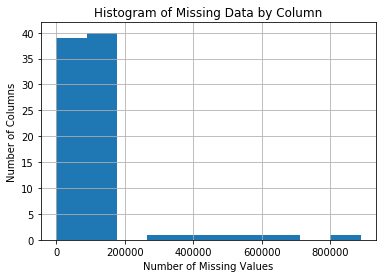

In [36]:
azdias_clean.isnull().sum().hist()
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Columns')
plt.title('Histogram of Missing Data by Column');

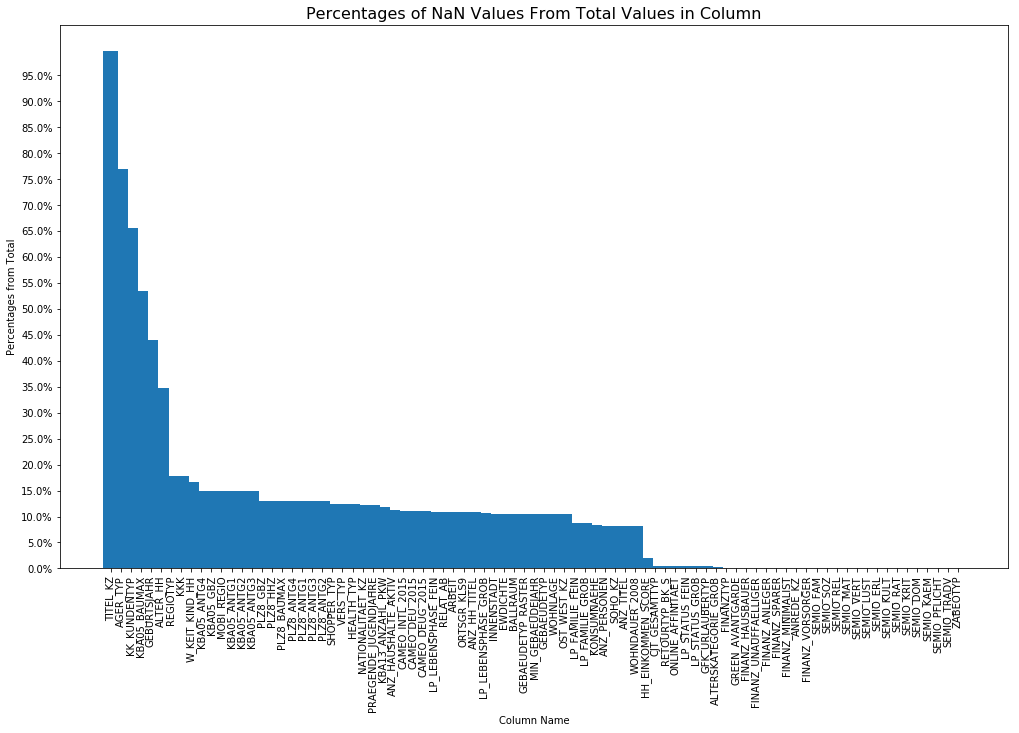

In [37]:
percentages = ((azdias_clean.isnull().sum()/azdias_clean.shape[0])*100).sort_values(ascending=False)

y_ticks = np.arange(percentages.values.min(), percentages.values.max(), 5)

y_labels = []
for i in y_ticks:
    y_labels.append(str(i) + '%')


fig_p, ax_p = plt.subplots(1,1, figsize = (17,10))

plt.xticks(np.arange(len(percentages.keys())),percentages.keys(), rotation = 90)
plt.yticks(y_ticks, y_labels)
plt.ylabel('Percentages from Total')
plt.xlabel('Column Name')
plt.title('Percentages of NaN Values From Total Values in Column', fontsize = 16)
plt.bar(x = np.arange(len(percentages.keys())), height = percentages.values, width = 1.5);

In [38]:
under_20 = percentages[percentages<20]

In [39]:
between_10_and_20 = under_20.count() - (under_20 > 10).sum()
between_10_and_20

39

In [40]:
(percentages == 0).sum()

24

In [41]:
def drop_high_null_volume_cols(df):
    '''This function drops all columns, where more than 20% of their values are missing.
    INPUT: 
        1. Dataframe
    OUTPUT:
        1. Dataframe without columns that have more than 20% of values missing
        2. List of columns that have been dropped, because more than 20% of ther values were missing
    '''
    percentages = ((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)
    dropped_columns = []
    for i in range(len(percentages)):
        if percentages.values[i] > 20:
            df.drop(columns = percentages.keys()[i], inplace = True)
            dropped_columns.append(percentages.keys()[i])
    return df, dropped_columns

In [42]:
def drop_attributes(df_feat, rows_to_drop):
    '''This function filters rows from dataset.
    INPUT: 
        1. Dataframe
        2. List of rows to be dropped
    OUTPUT:
        1. Dataframe without rows to be dropped
        '''
    for value in rows_to_drop:
        df_feat = df_feat[df_feat['attribute'] != value]
    return df_feat

In [43]:
azdias_clean, dropped_cols = drop_high_null_volume_cols(azdias_clean)

In [44]:
dropped_cols

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [45]:
feat_info_clean = drop_attributes(feat_info_clean, dropped_cols)

In [46]:
azdias_clean.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

**ANSWER:**

There are 35 columns in which more than 10% of data is naturally missing. The columns with the highest percentage of missing values is `KK_KUNDENTYP` with about 65.5% of data missing. 

After replacing all values encoded in the `missing_or_unknown` column of the `feat_info_clean` dataframe with `np.nan` values in the `azdias_clean` dataframe the distribution of missing values increased about 71%. Some columns such as `AGER_TYP` went from having no naturally missing values to having about 77% of their values missing. 

After replacement the histogram *Histogram of Missing Data by Column* shows there are about 5 columns that have more than 200.000 missing values. Given that the dataframe has a total of 891.221 this amount of missing values would represent about 23% or more missing data in the column. 

A more in depth analysis of columns with missing data shows that more than 95% of data is missing the  `TITEL_KZ`  column. Before the replacement this column already had a high number of naturally missing values, however, replacement further increased this number. Following the `TITEL_KZ` column are the `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`, `GEBURTSJAHR`, and `ALTER_HH` with about 77%, 66%, 53%, 44% and 34%  of missing data respectively. Given the high amount of missing values in these columns, they were excluded of the dataset.

Interestingly, after the replacement most columns have around 10% and 20% of missing values. Only 24 of the 85 columns have no missing data. This points to the fact that the dataset will have to be cleaned further in the next sections.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

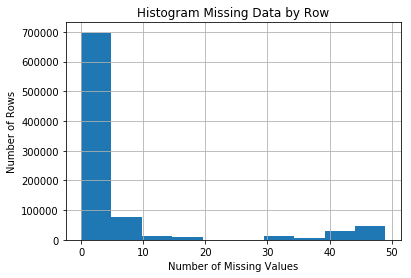

In [47]:
azdias_clean.isnull().sum(axis = 1).hist()
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Histogram Missing Data by Row');

In [48]:
azdias_low_null_count = azdias_clean[azdias_clean.isnull().sum(axis = 1) < 25]
azdias_high_null_count = azdias_clean[azdias_clean.isnull().sum(axis = 1) >= 25]

In [49]:
azdias_low_null_count.shape[0]/azdias_clean.shape[0]*100

89.5295330787762

In [50]:
azdias_high_null_count.shape[0]/azdias_clean.shape[0]*100

10.470466921223805

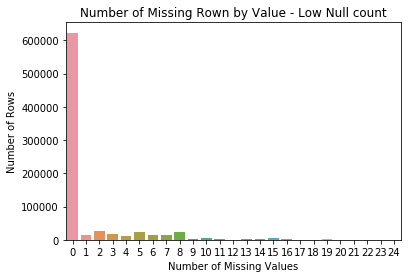

In [51]:
sns.countplot(azdias_low_null_count.isnull().sum(axis =1));
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Number of Missing Rown by Value - Low Null count');

In [52]:
(azdias_low_null_count.isnull().sum(axis =1) > 0).sum()/azdias_low_null_count.shape[0]*100

21.894433680157814

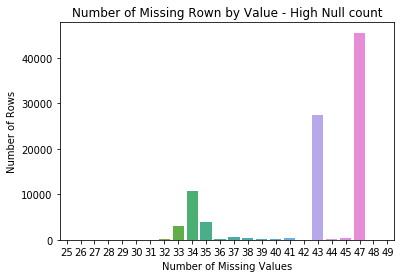

In [53]:
sns.countplot(azdias_high_null_count.isnull().sum(axis =1))
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Number of Missing Rown by Value - High Null count');

In [54]:
(azdias_high_null_count.isnull().sum(axis =1) > 43).sum()/azdias_high_null_count.shape[0]*100

49.541874296736857

In [55]:
comp_columns = azdias_low_null_count.isnull().sum().sort_values(ascending = True)[:7].keys()

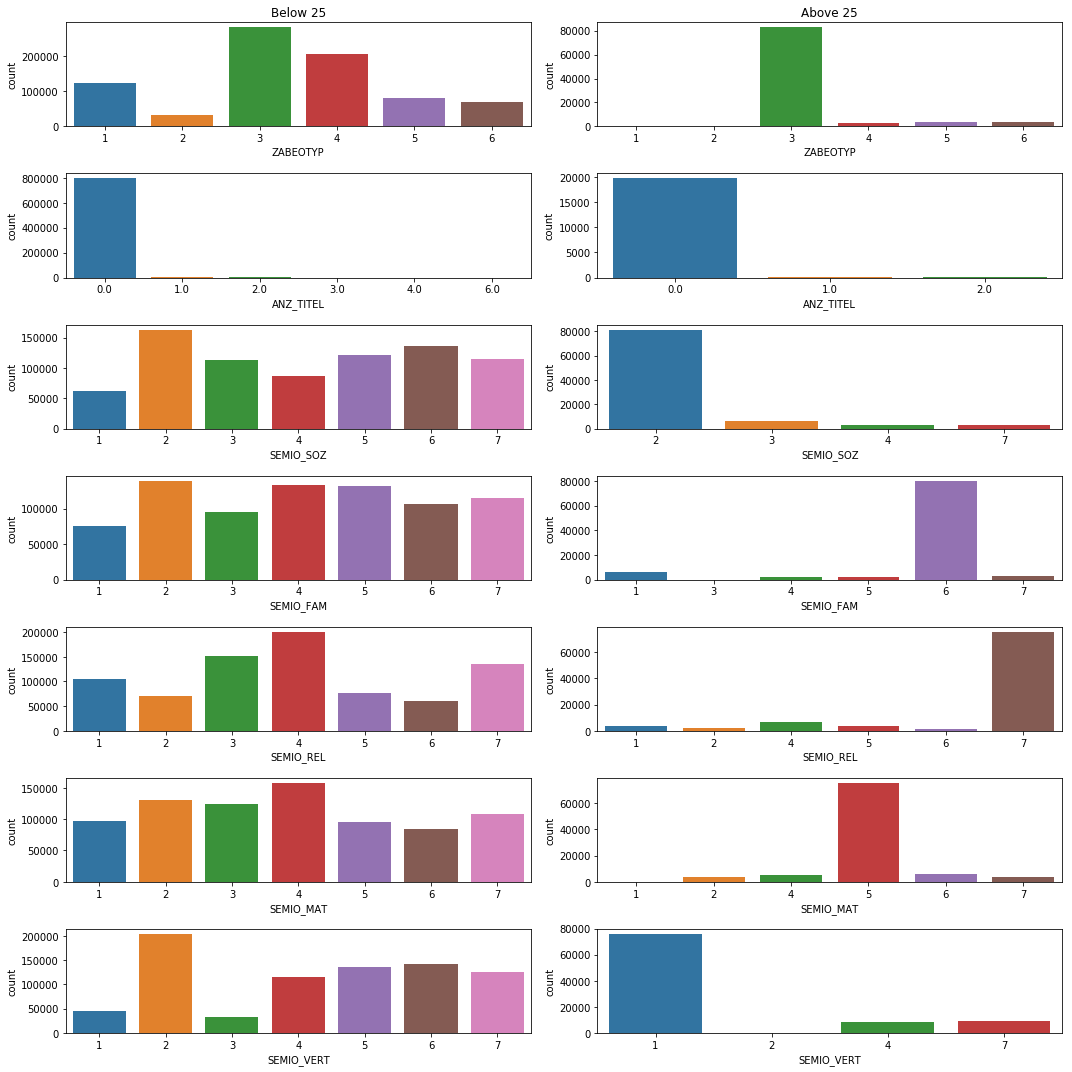

In [56]:
comp_fig, comp_ax = plt.subplots(nrows = 7, ncols= 2, figsize = (15,15));
pos = 0
for column in comp_columns:
    sns.countplot(azdias_low_null_count[column], ax = comp_ax[pos,0])
    comp_ax[0][0].set_title('Below 25')
    comp_ax[pos][0].set_xlabel(column)
    sns.countplot(azdias_high_null_count[column], ax = comp_ax[pos,1])
    comp_ax[0][1].set_title('Above 25')
    pos += 1
    plt.tight_layout()



#### Discussion 1.1.3: Assess Missing Data in Each Row

**ANSWER:**

The histogram *Histogram Missing Data by Row* shows that there is one group of rows that have less than 25 missing values per row and a group that has more than 25 missing values per row. The first group refered to as `azdias_low_null_count` contains about 90% of the rows of the dataset whereas the second group called `azdias_high_null_count` contains about 10% of the rows. This is suggests that the largest part of the dataset had a low null value count. 

Diving deeper into the count of missing values in the `azdias_low_null_count` group we can see the majority of rows have 0 missing values. Only 21% of the rows in this group have more than 0 missing values. The `azdias_high_null_count` shows that 49% of rows have 43 ore more missing values, which is  54% or more of the data in a row.

If we compare the distribution of values for the 7 columns  `ZABEOTYP`, `ANZ_TITEL`, `SEMIO_SOZ`, `SEMIO_FAM`, `SEMIO_REL`, `SEMIO_MAT`, `SEMIO_VERT` where there are no missing values between the two subsets `azdias_low_null_count` and `azdias_high_null_count` we can see that the distributions are very different. Only the columns `ANZ_TITEL` has a similar distribution. Given that most rows in this column have the value 0 it could be argued that dropping these points in the `azdias_high_null_count` would not present a major issue. However, in the other columns the different distributions point to this data being special.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [242]:
feat_info_clean.type.value_counts()

ordinal        49
categorical    12
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [58]:
def get_type_values(df, string):
    '''This functions extracts the names of all attributes of provided data type.
    INPUT:
        1. Dataframe
        2. Datatype of feature
    OUTPUT: 
        1. List with all attribute names of provided data type
        '''
    return df[df['type'] == string]['attribute'].values


In [59]:
def filter_categoricals(df, column_values):
    '''This function assesses what type of categorical a specific column is.
    INPUT:
        1. Dataframe
        2. Column names of categoricals
    OUTPUT:
        1. List of all binary categoricals that take numeric values
        2. List of all binary categoricals that take non-numeric values
        3. List of multi_level categorical
        '''
    binary = []
    binary_reencode = []
    multi_level = []
    for value in column_values:
        values = df[value].unique()
        if df[value].nunique() == 2:
            if isinstance(values[0], np.int64) or isinstance(values[0], np.float64):
                binary.append(value)
            else:
                binary_reencode.append(value)
        else:
            multi_level.append(value)
    return binary, binary_reencode, multi_level

In [60]:
def create_dummy_variables(df, feat_df, string = 'categorical'):
    ''' This function creates a dataframe with dummies
    INPUT:
        1. Dataframe to which to add dummy variables
        2. Dataframe where type of column name is encoded (e.g 'categorical')
        3. Feature data type
    OUTPUT:
        1. Datafram with dummy variables
        '''
    binary, binary_reencode, multi_level = filter_categoricals(df, get_type_values(feat_df, string))
    df = pd.get_dummies(data = df, columns = binary_reencode)
    df = pd.get_dummies(data =df, columns = multi_level)
    return df

In [61]:
categorical = get_type_values(feat_info_clean, 'categorical')
binary, binary_reencode, multi_level = filter_categoricals(azdias_low_null_count, categorical)
print("Binary categoricals: {}\nBinary categoricals to reencode: {}\nMulti level categoricals: {}".format(binary,binary_reencode, multi_level))

Binary categoricals: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
Binary categoricals to reencode: ['OST_WEST_KZ']
Multi level categoricals: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [62]:
drop_multi_level = ['CJT_GESAMTTYP','FINANZTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP','CAMEO_DEU_2015']
azdias_low_null_count.drop(columns = drop_multi_level, inplace = True)
feat_info_clean = drop_attributes(feat_info_clean, drop_multi_level)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [63]:
azdias_low_null_count = create_dummy_variables(azdias_low_null_count, feat_info_clean)

In [64]:
azdias_low_null_count.rename(columns = {'OST_WEST_KZ_O': 'OST_WEST_KZ_OW'}, inplace = True)

In [65]:
azdias_low_null_count.drop(columns = 'OST_WEST_KZ_W', inplace = True)

#### Discussion 1.2.1: Re-Encode Categorical Features

**ANSWER:**

An analysis of all categorical columns shows that there are 4 binary categoricals with numeric values that can be kept,  one categorical binary `OST_WEST_KZ` with non-numeric value that should be re-econded and 13 multi-level categoricals that have to be assessed. 

The categorical binary with non-numeric value was re-encoded to 0 for *W* (west) and 1 for *O* (east) in the new column `OST_WEST_KZ_OW`.

From the 13 multi-level categoricals `CJT_GESAMTTYP`, `FINANZTYP`, `LP_FAMILIE_FEIN`,  `LP_STATUS_FEIN`, `GEBAEUDETYP`, `CAMEO_DEU_2015` were dropped. The reasoning being as follows:

- `CJT_GESAMTTYP`: To reduce complexity of further analysis this column was dropped
- `FINANZTYP`: The columns `FINANZ_MINIMALIST`, `FINANZ_SPARER`, `FINANZ_VORSORGER`, `FINANZ_ANLEGER`, `FINANZ_UNAUFFAELLIGER`, `FINANZ_HAUSBAUER` already encode this information in more detail. Therefore this column is not necessary. 
- `LP_FAMILIE_FEIN`: The column `LP_FAMILIE_GROB` contains the same information in less detail, therefore this column is not necessary
- `LP_STATUS_FEIN`: The column `LP_STATUS_GROB` contains the same information in less detail, therefore this column is not necessary
- `GEBAEUDETYP`: To reduce complexity of further analysis this column was dropped
- `CAMEO_DEU_2015`:  The column `CAMEO_DEUG_2015` contains the same information in less detail, therefore this column is not necessary

The other 7  multi-level variables  `GFK_URLAUBERTYP`, `LP_FAMILIE_GROB`,  `LP_STATUS_GROB`, `NATIONALITAET_KZ`, `SHOPPER_TYP`, `ZABEOTYP`, and `CAMEO_DEUG_2015`, were reencoded as dummy variables because they were deemed important for further analysis given the following reasoning:

- `GFK_URLAUBERTYP`: Kept to have information about vacation habits of customers that might be relevant to their consumer behavior
- `LP_FAMILIE_GROB`: Kept because `LP_FAMILIE_FEIN` was dropped
- `LP_STATUS_GROB`: Kept because `LP_STATUS_FEIN` was dropped
- `NATIONALITAET_KZ`: Kept to have information about consumers nationality
- `SHOPPER_TYP`: Kept to have information about the shopper typology of the customers
- `ZABEOTYP`: Kept to have information about the energy consumption habits of customers 
- `CAMEO_DEUG_2015`: Kept because `CAMEO_DEU_2015` was dropped

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [66]:
def reencode_mixed_values(df, column_name, values_dict, new_column_name):
    '''This functions creates a new column replacing a set of defined values (re-encode column) on provided dataframe
    INPUT: 
        1. Dataframe
        2. Names of columns in dataframe to be re-encoded
        3. Dictionary mapping values to replacement values
        4. New column name for columns with replaced value
    OUTPUT:
        1. None
        '''
    df[new_column_name] = df[column_name].replace(values_dict)

In [67]:
def reencode_clean_all_mixed(df, df_feat, column_names_replace, values_dict, new_column_name, string = 'mixed'):
    '''This created multiple new columns with replaced values (re-encoded columns) and drops original columns
    INPUT:
        1. Dataframe
        2. Dataframe where type of column name is encoded
        3. Names of columns in dataframe to be re-encoded
        4. Dictionary mapping values to replacement values
        5. New column name for columns with replaced value
        6. Data type of feature
        Data type of feature
    OUTPUT:
        1. Dataframe with new encoded columns
        2. List of original columns that were dropped
        '''
    for i in range(len(new_column_name)):
        reencode_mixed_values(df = df, column_name = column_names_replace[i], 
                values_dict = values_dict[i], new_column_name = new_column_name[i])
    mixed = get_type_values(df_feat, string)
    df.drop(columns = mixed, inplace = True)
    return df, mixed


In [68]:
#'PRAEGENDE_JUGENDJAHRE'
decades = {1.0: 40.0, 2.0: 40.0, 3.0: 50.0, 4.0: 50.0, 5.0: 60.0, 6.0: 60.0,
                                     7.0: 60.0, 8.0: 70.0, 9.0: 70.0, 10.0: 80.0, 11.0: 80.0, 12.0: 80.0,
                                     13.0: 80.0, 14.0: 90.0, 15.0: 90.0}
movement = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8:0, 9: 1, 10:0, 11: 1, 12:0, 13: 1, 14: 0, 15: 1}
#'CAMEO_INTL_2015'
wealth = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,
          '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,
          '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,
          '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,
          '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 5.0}
life_stage = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,
              '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,
              '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,
              '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,
              '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}


In [69]:
columns_to_replace = ['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015', 'CAMEO_INTL_2015']
value_dicts = [decades, movement, wealth, life_stage]
new_column_names = ['DECADE', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE']

azdias_low_null_count, dropped_mixed_cols = reencode_clean_all_mixed(df = azdias_low_null_count, df_feat = feat_info_clean,
                                                              column_names_replace = columns_to_replace, values_dict = value_dicts,
                                                              new_column_name = new_column_names)

In [70]:
feat_info_clean = drop_attributes(feat_info_clean, dropped_mixed_cols)

#### Discussion 1.2.2: Engineer Mixed-Type Features

**ANSWER:**

Both `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` were engineered. 
Using the `Data_Dictionary.md` file as reference `PRAEGENDE_JUGENDJAHRE`  was divided into `DECADE` and `MOVEMENT` whereas `CAMEO_INTL_2015` was divided to `WEALTH` and `LIFE_STAGE`. This was done by creating a dictionary with the values to be replaced and using the `.replace()` function of Pandas. The original columns where dropped after the engineering step. 

Other mixed columns were dropped using following logic:

- `LP_LEBENSPHASE_FEIN`: This column contains information on the wealth and family status of consumers. This information is indirectly provided by `CAMEO_INT_2015` and therefore present in the engineered columns. So this columns was dropped.
- `LP_LEBENSPHASE_GROB`: Contains the same information as the previously discussed column with less detail and is therefore not necessary.
- `WOHNLAGE`: Dropped to reduce complexity
- `PLZ8_BAUMAX`: Dropped to reduce complexity

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [71]:
feat_info_clean.type.value_counts()

ordinal        49
categorical    12
numeric         6
Name: type, dtype: int64

In [72]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [73]:
ordinal_clean = get_type_values(feat_info_clean, 'ordinal')
numeric_clean = get_type_values(feat_info_clean, 'numeric')
categorical_clean = get_type_values(feat_info_clean, 'categorical')

required_columns = [*ordinal_clean, *numeric_clean, *categorical_clean]

In [74]:
columns_dataset = azdias_low_null_count.columns

In [75]:
def check_missing_values(required_values, df_columns):
    '''This function takes compares to list of values.
    INPUT: 
        1. List of values a
        2. List of values b
    OUTPUT:
        1. List of values that were in list a but not in b
        '''
    missing_val = []
    for col in required_values:
        if col not in df_columns:
            missing_val.append(col)
    return missing_val

In [76]:
missing_from_dataset = check_missing_values(required_columns, columns_dataset)

In [77]:
missing_from_dataset

['GFK_URLAUBERTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015']

In [78]:
dropped_cat_cols = [*binary_reencode, *multi_level, *drop_multi_level]

In [79]:
check_missing_values(missing_from_dataset, dropped_cat_cols)

[]

In [80]:
dropped_cols_total = [*dropped_cat_cols, *dropped_cols, *dropped_mixed_cols]

In [81]:
ordinal_orig = get_type_values(feat_info, 'ordinal')
categorical_orig = get_type_values(feat_info, 'categorical')
mixed_orig = get_type_values(feat_info, 'mixed')
numeric_orig = get_type_values(feat_info, 'numeric')
interval_orig = get_type_values(feat_info, 'interval')

required_original = [*ordinal_orig, *categorical_orig, *mixed_orig, *numeric_orig, *interval_orig]

In [82]:
missing_from_dataset_orig = check_missing_values(required_original, columns_dataset)

In [83]:
check_missing_values(missing_from_dataset_orig, dropped_cols_total)

[]

In [84]:
def check_for_correct_dummies(df_columns, column_for_dummy):
    '''This function checks if dummy variables were correctly created
    INPUT:
        1. List of all columns in data set (with dummies)
        2. List of original columns that had to be re-encoded als dummy variables
    OUTPUT:
        1. All column names/patterns checked
        2. List of resulting dummies from data set
        '''
    checked_patterns = []
    created_dummies = []
    for col in df_columns:
        for pattern in column_for_dummy:
            if re.search(pattern + '[_][OW\d]', col):
                created_dummies.append(col)
                if pattern not in checked_patterns:
                    checked_patterns.append(pattern)
    return checked_patterns, created_dummies

In [85]:
columns_for_dummy_col = [*binary_reencode, *multi_level]

In [86]:
columns_for_dummy_col

['OST_WEST_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [87]:
columns_for_dummy_col = check_missing_values(columns_for_dummy_col, drop_multi_level)

In [88]:
checked_columns, created_dummies = check_for_correct_dummies(columns_dataset, columns_for_dummy_col)

In [89]:
check_missing_values(checked_columns,columns_for_dummy_col)

[]

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [127]:
def clean_data(df, df_feat):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        1. Demographics DataFrame
        2. Dataframe with feature attributes for demographics data
    OUTPUT: 
        1. Trimmed and cleaned demographics DataFrame
        2. Trimmed and cleaned Dataframe with feature attributes for demographics data
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    characters = ['\[', '\]']
    eliminate_characters(df_feat.missing_or_unknown, characters)
    df_feat.missing_or_unknown = df_feat.missing_or_unknown.str.split(',')
    unknown_missing_values_list = df_feat.missing_or_unknown.tolist()
    convert_to_float(unknown_missing_values_list)
    column_names = df.columns
    df = df.replace(replace_by_nan(unknown_missing_values_list, column_names))
    # remove selected columns and rows, ...
    columns_to_drop = ['TITEL_KZ','AGER_TYP',
                       'KK_KUNDENTYP','KBA05_BAUMAX',
                       'GEBURTSJAHR','ALTER_HH',
                       'CJT_GESAMTTYP','FINANZTYP', 
                       'LP_FAMILIE_FEIN','LP_STATUS_FEIN',
                       'GEBAEUDETYP','CAMEO_DEU_2015']
    df.drop(columns = columns_to_drop, inplace = True)
    #df, columns_to_drop = drop_high_null_volume_cols(df)
    
    df_feat = drop_attributes(df_feat, columns_to_drop)
    
    df_low = df[df.isnull().sum(axis = 1) < 25]
    
    df_high = df[df.isnull().sum(axis = 1) >= 25]
    
    
    df_low = create_dummy_variables(df_low, df_feat, string = 'categorical')
    
    df_low.rename(columns = {'OST_WEST_KZ_O': 'OST_WEST_KZ_OW'}, inplace = True)
    df_low.drop(columns = 'OST_WEST_KZ_W', inplace = True)
    
    decades = {1.0: 40.0, 2.0: 40.0, 3.0: 50.0, 4.0: 50.0, 5.0: 60.0, 6.0: 60.0,
               7.0: 60.0, 8.0: 70.0, 9.0: 70.0, 10.0: 80.0, 11.0: 80.0, 12.0: 80.0,
               13.0: 80.0, 14.0: 90.0, 15.0: 90.0}
            
    movement = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8:0, 9: 1, 10:0, 11: 1, 12:0, 13: 1, 14: 0, 15: 1}

    wealth = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,
          '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,
          '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,
          '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,
          '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 5.0}
    life_stage = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,
              '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,
              '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,
              '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,
              '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}
    
    columns_to_replace = ['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015', 'CAMEO_INTL_2015']
    value_dicts = [decades, movement, wealth, life_stage]
    new_column_names = ['DECADE', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE']
    
    df_low, columns_to_drop = reencode_clean_all_mixed(df=df_low, df_feat = df_feat, column_names_replace = columns_to_replace,
                              values_dict = value_dicts, new_column_name = new_column_names)
    
    
    df_feat = drop_attributes(df_feat, columns_to_drop)
    
    return df_low, df_high, df_feat

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [92]:
azdias_low_null_count.isnull().sum().sort_values(ascending = False)[:10]

KKK               64764
REGIOTYP          64764
W_KEIT_KIND_HH    59227
KBA05_ANTG4       40009
KBA05_ANTG1       40009
KBA05_ANTG2       40009
KBA05_ANTG3       40009
KBA05_GBZ         40009
MOBI_REGIO        40009
HEALTH_TYP        36671
dtype: int64

In [93]:
test = azdias_low_null_count[azdias_low_null_count.isnull().sum(axis = 1) == 0]  

In [94]:
1-(test.shape[0]/azdias_low_null_count.shape[0])

0.21894183024065494

In [95]:
imputer = Imputer(missing_values = np.nan, strategy = 'median')
azdias_no_null = pd.DataFrame(imputer.fit_transform(azdias_low_null_count))

In [96]:
#Check if Imputer worked
print(azdias_no_null.isnull().sum().sum())
print(azdias_no_null.isnull().sum(axis = 1).sum())

0
0


In [97]:
scaler = StandardScaler()
scaler_fit_trans =scaler.fit_transform(azdias_no_null)

In [98]:
azdias_final = pd.DataFrame(scaler_fit_trans)

In [99]:
azdias_final.columns = azdias_low_null_count.columns

In [100]:
azdias_final.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766583,0.957932,-1.494563,1.537958,-1.040677,1.466028,0.958855,1.339191,-0.530442,1.096516,...,-0.386920,-0.272885,-0.391135,-0.329005,2.221523,-0.396028,1.172889,-0.530442,1.186174,-1.266961
1,0.200534,0.957932,-1.494563,0.864598,-1.766947,-0.570971,0.244297,1.339191,1.885219,1.096516,...,2.584513,-0.272885,-0.391135,-0.329005,-0.450142,-0.396028,1.172889,1.885219,-0.868201,0.761246
2,1.184092,0.957932,0.683201,-0.482123,1.138132,-0.570971,-1.184817,-0.791446,-0.530442,-0.257063,...,-0.386920,-0.272885,-0.391135,-0.329005,-0.450142,-0.396028,-0.223438,-0.530442,-1.552992,-0.590892
3,0.200534,-1.043916,0.683201,0.191237,0.411863,-1.249970,0.244297,-0.791446,-0.530442,1.096516,...,-0.386920,-0.272885,2.556661,-0.329005,-0.450142,-0.396028,-0.223438,-0.530442,0.501382,0.085177
4,-1.766583,0.957932,-0.042721,-1.155483,1.138132,-0.570971,-0.470260,1.339191,-0.530442,1.096516,...,-0.386920,-0.272885,-0.391135,-0.329005,2.221523,-0.396028,-1.619764,-0.530442,1.186174,0.761246


In [101]:
azdias_final.shape

(797906, 108)

### Discussion 2.1: Apply Feature Scaling

**ANSWER:**

A quick look at the data shows that after the re-encoding and re-engineering of columns there are still missing values in the `azdias_low_null_count` dataset. Only about 22% of the rows over all columns have zero missing values. Given that we do not want to loose too much data by eliminating all rows with missing values, an sklearn Imputer was used to fill the missing values with the median. The median was chosen to create the imputer to avoid outliers from influencing the values used to replace the missing data. 

To prepare data for PCA and clustering a sklearn Standard Scaler was user to scale all data to a z-score (z = (x - u) / sd).

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [102]:
pca = PCA(n_components = azdias_final.shape[1])
X_pca = pca.fit_transform(azdias_final)

In [103]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    if num_components < 80:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.tight_layout()

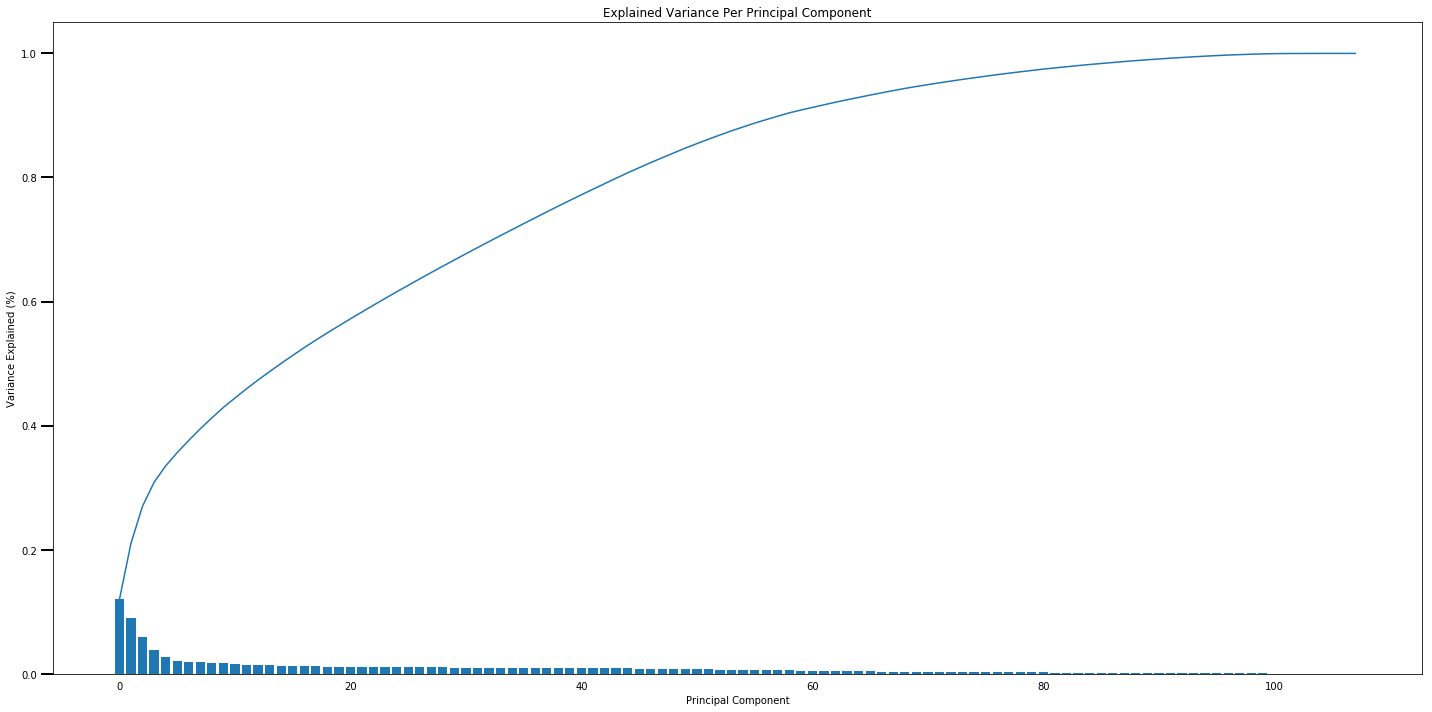

In [104]:
scree_plot(pca)

In [105]:
temp = 0
temp_old = 0
interval_step = 5
for feature_num in np.arange(5, 80, interval_step):
    
    temp = pca.explained_variance_ratio_[:feature_num].sum()
    print('The variance explained by the first {} features amounts to: {:.2f}'.format(feature_num, 
                                                                                  temp))
    print('Average variance increase per feature in this interval amounts to: {:.4f}\n'.format(((temp-temp_old)/interval_step)))
    temp_old = temp

The variance explained by the first 5 features amounts to: 0.34
Average variance increase per feature in this interval amounts to: 0.0670

The variance explained by the first 10 features amounts to: 0.43
Average variance increase per feature in this interval amounts to: 0.0189

The variance explained by the first 15 features amounts to: 0.50
Average variance increase per feature in this interval amounts to: 0.0142

The variance explained by the first 20 features amounts to: 0.56
Average variance increase per feature in this interval amounts to: 0.0121

The variance explained by the first 25 features amounts to: 0.62
Average variance increase per feature in this interval amounts to: 0.0110

The variance explained by the first 30 features amounts to: 0.67
Average variance increase per feature in this interval amounts to: 0.0103

The variance explained by the first 35 features amounts to: 0.72
Average variance increase per feature in this interval amounts to: 0.0098

The variance explaine

In [106]:
pca = PCA(n_components = 25)
X_pca = pca.fit_transform(azdias_final)

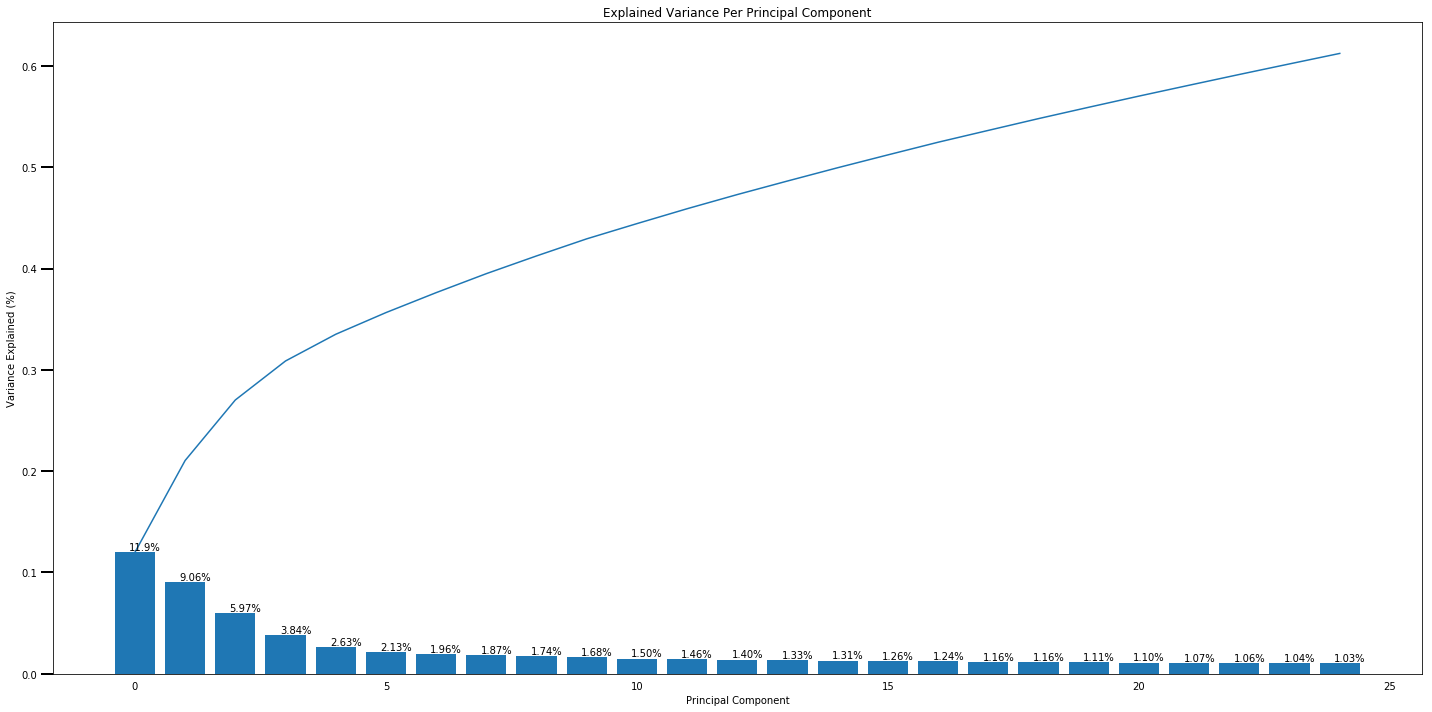

In [107]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

**ANSWER:**

A PCA object was created to fit and transform the `azdias_clean` dataset. In the first scree plot generated to see the eigenvalues of each eigenvector, we can recognize that the first 4 dimensions already explain a large part of the variance. A more detailed analysis of the eigenvalues shows that the first five dimension explain 34% of the eigenvalue and each of the features is responsible for an average of 0.06 increase in the variance. The average increase in variance explained by each feature starts stagnating at around 20 features. To encompass as much information as possible through the eigenvectors while substantially reducing the number of features in the dataset 25 principal components were retained for the next step of the analysis. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [108]:
def helper_for_pca(full_dataset, pca):
    '''This function get the dimensions and the weights per feature of the PCA results
    INPUT: 
        1. Dataframe
        2. Principal component Analysis results
    OUTPUT: 
        1. Dimensions of PCA
        2. Weights of each feature of PCA
        '''
   
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    return dimensions, components

In [109]:
def pca_results(full_dataset, pca):
    '''
    This function create a DataFrame with relevant information about the results of the PCA. 
    INPUT:
        1. Dataframe
        2. Principal component Analysis results
    OUTPUT:
        1. Dataframe with PCA results that includes dimension feature weights and explained variance
    
    '''
   
    dimensions, components = helper_for_pca(full_dataset, pca)
    components.index = dimensions
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    return pd.concat([variance_ratios, components], axis = 1)

In [110]:
def plot_pca_results(full_dataset, pca, n_dim_in_plot):
    '''This function visualizes the results of the PCA by dimension including the weight of each feature and
    the explained variance
    INPUT:
        1. Dataframe
        2. PCA results
        3. Number of dimensions in one plot
    OUTPUT:
        1. None
        '''
    dimensions, components = helper_for_pca(full_dataset, pca)
    step = n_dim_in_plot
    start = 0
    end = step
    r = int(np.ceil(len(dimensions)/3))
    
    for i in range(r):
        if end > (len(dimensions)):
            end = (len(dimensions))+1 
            
        fig, ax = plt.subplots(figsize = (14,8))
        slice_comp = components[start:end]
        slice_comp.plot(ax = ax, kind = 'bar')
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dimensions[start:end], rotation=0)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        for i, ev in enumerate(pca.explained_variance_ratio_[start:end]):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
        start = end
        end+=step

In [111]:
def plot_pca_by_dimension(full_dataset, pca, dimension_name, figsize):
    '''This function visualizes the PCA results of one single dimension including the weight of each feature and
    the explained variance
    INPUT:
        1. Dataframe
        2. PCA results
        3. Dimension to be plotted
        4. Figure size
    OUTPUT:
        1. None
        '''
    dimensions, components = helper_for_pca(full_dataset, pca)
    loc = dimensions.index(dimension_name)
    comp_sorted = components.iloc[loc].sort_values(ascending = False)
    x = np.arange(len(comp_sorted.keys()))
    y = comp_sorted.values
    plt.figure(figsize = figsize)
    plt.xticks(x ,comp_sorted.keys(), rotation = 90)
    plt.ylabel('Feature Weights')
    plt.title(dimension_name + ' - Explained Variance Ratio {:.4f}'.format(pca.explained_variance_ratio_[loc]), fontsize = 14)
    plt.bar(x,y)

In [112]:
result_matrix = pca_results(azdias_final, pca)

In [113]:
result_matrix.head()

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
Dimension 1,0.1198,-0.0944,0.0156,-0.2041,0.1245,-0.0926,0.0593,0.0558,0.1582,-0.1125,...,-0.0780,-0.0114,0.0030,0.0368,0.0998,0.1230,0.0793,-0.1125,0.1996,-0.1191
Dimension 2,0.0906,0.2490,0.0750,0.0755,-0.2296,0.2255,-0.1968,-0.2173,0.1012,-0.0112,...,-0.0350,-0.0061,0.0142,0.0119,0.0392,0.0211,-0.2448,-0.0112,0.0611,0.0084
Dimension 3,0.0598,0.0578,-0.3543,0.1392,-0.0889,0.0862,-0.1742,-0.0849,-0.0367,0.0496,...,-0.0274,-0.0036,-0.0006,0.0017,0.0197,0.0265,-0.0913,0.0496,0.0331,-0.0145
Dimension 4,0.0385,-0.0365,0.0499,0.0302,0.0048,-0.0201,-0.0933,0.0607,-0.0620,0.3508,...,-0.0467,0.0239,-0.0359,-0.0199,-0.0160,-0.0142,0.0376,0.3508,-0.0801,0.0360
Dimension 5,0.0264,0.0540,-0.0232,0.0663,-0.0161,-0.0005,0.0496,-0.0789,-0.0651,-0.0864,...,0.0099,-0.0319,-0.0111,-0.0090,0.0428,0.0579,0.0116,-0.0864,0.0785,-0.0433


In [114]:
# Uncomment to plot weights and explained variance per dimension
# for all dimensions
#plot_pca_results(azdias_final, pca, 3)

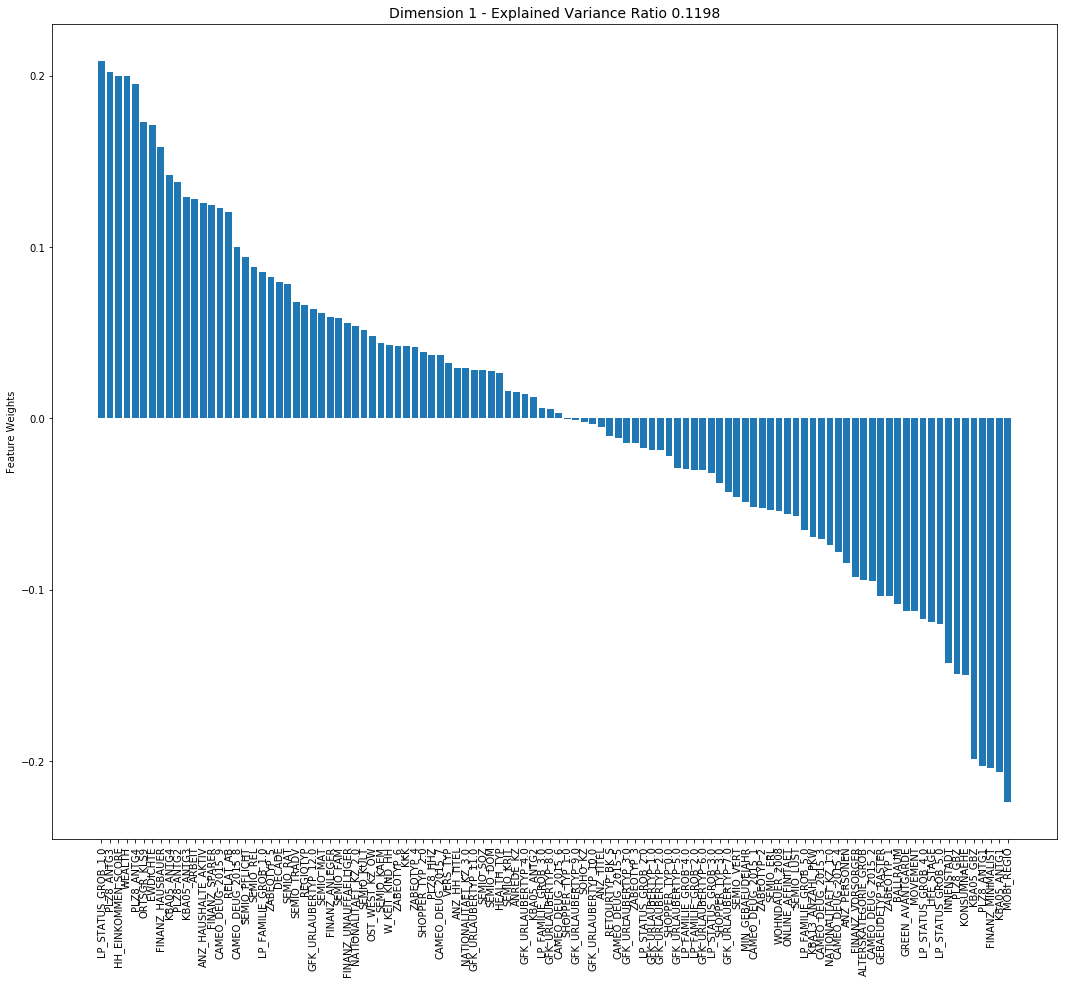

In [115]:
plot_pca_by_dimension(azdias_final, pca, 'Dimension 1', (18,15))

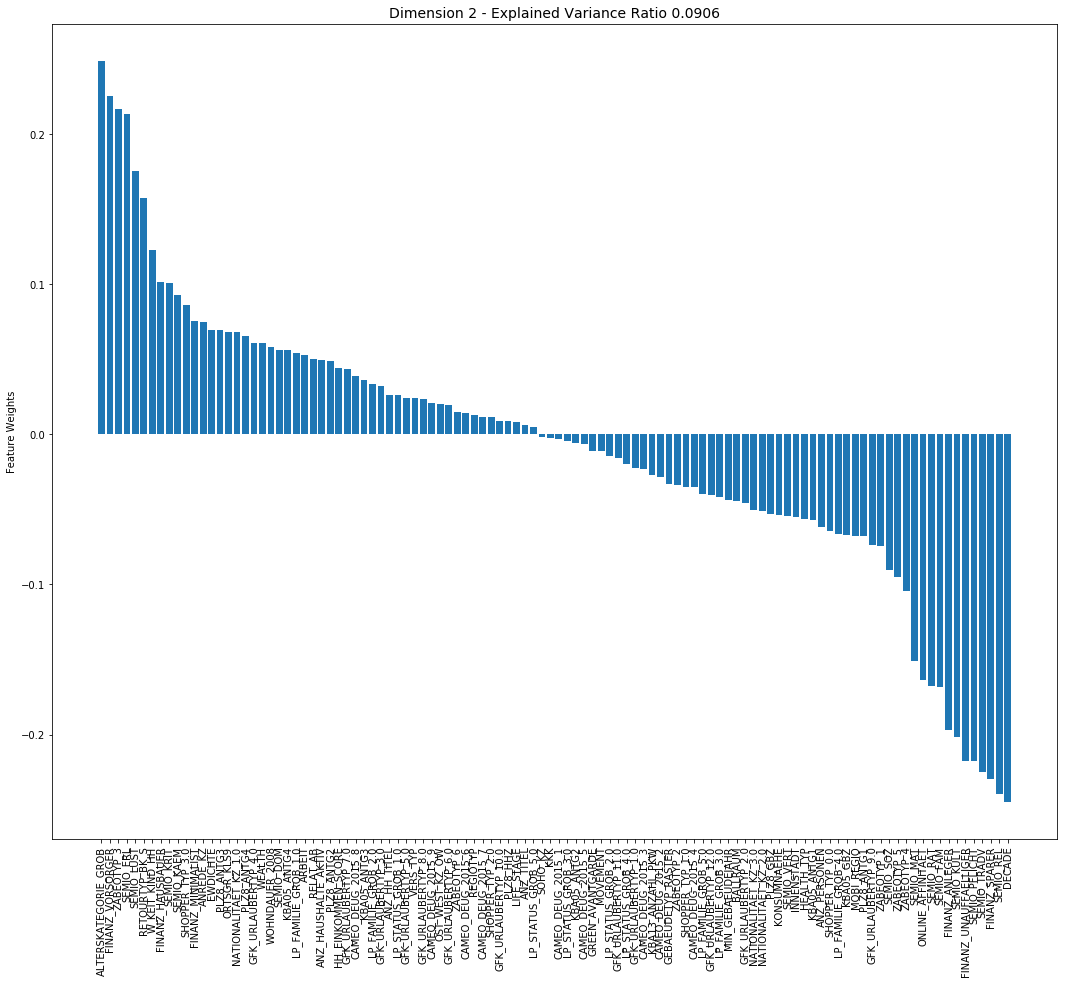

In [116]:
plot_pca_by_dimension(azdias_final, pca, 'Dimension 2', (18,15))

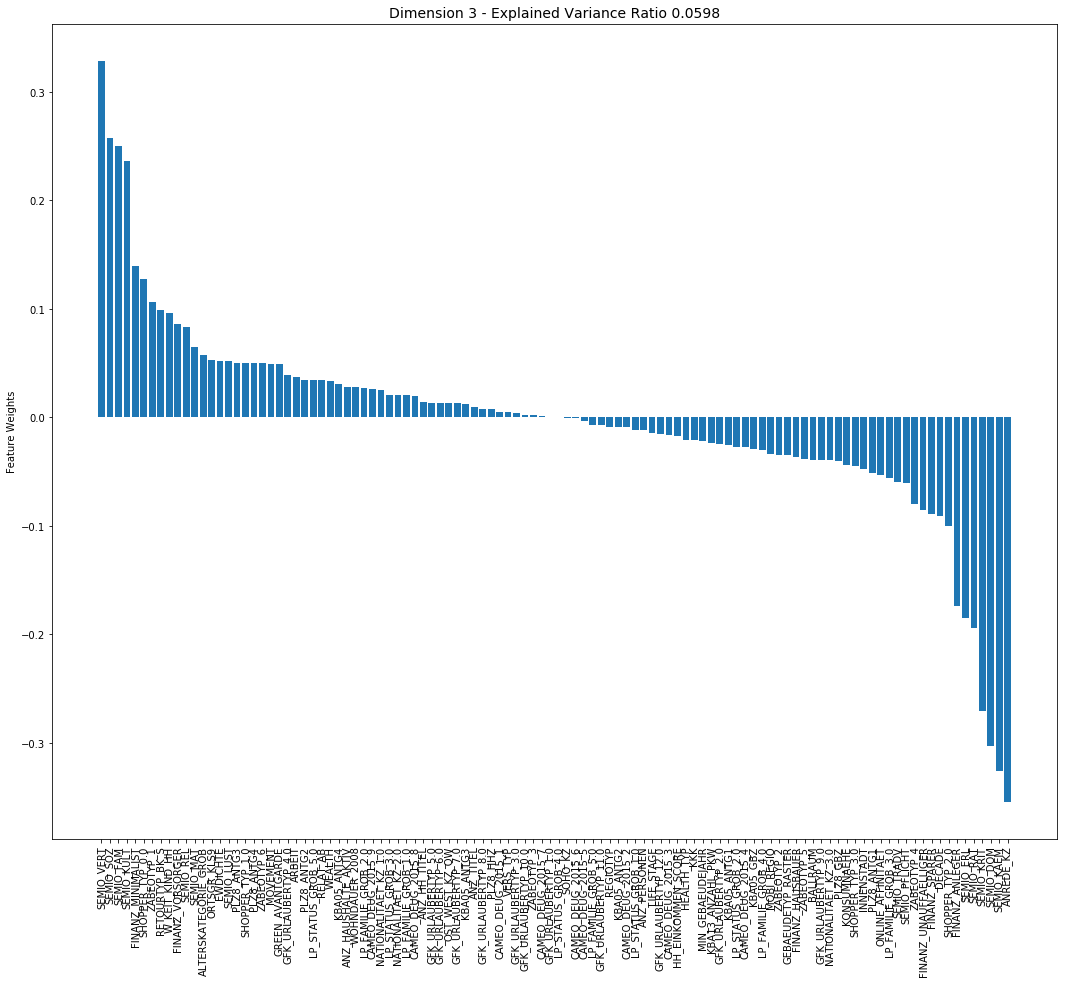

In [117]:
plot_pca_by_dimension(azdias_final, pca, 'Dimension 3', (18,15))

### Discussion 2.3: Interpret Principal Components

The first three principal components explain around 27% of the variance and will therefore be analyzed in more detail. Only the top three positively weighted and top three negatively weighted features will be considered in this scenario.  

*__Dimension 1:__*

|FEATURE | DESCRPTION|TYPE
|---|--------|---|
|LP_STATUS_GROB_1.0|low-income earners|+|
|PLZ8_ANTG3|Number of 6-10 family houses in the PLZ8 region|+|
|HH_EINKOMMEN_SCORE|Estimated household net income|+|
|MOBI_REGIO|Movement patterns|-|
|KBA05_ANTG1|Number of 1-2 family houses in the microcell|-|
|FINANZ_MINIMALIST|Financial typology of low financial interest individuals|-|

*Interpretation:*

The first eigenvector positively weights items related to the income of individuals. The explanation of the features in the `Data_Dictionary.md`suggest that we are looking at lower income individuals. Family houses with 6-10 families seem to be prevalent in the area. Furthermore, the household income is positively weighted, this suggest that this variable is correlated to the `LP_STATUS_GROB_1.0`.
Negatively weighted features in the first eigenvector are the mobility patterns. The number of 1-2 family houses in the microcell, i.e. in the area, and the feature describing the typology of individuals with low financial interest. One can assume that `PLZ8_ANTG` and `KBA05_ANTG1` are negatively correlated, since if the concentration of 6-10 family houses is high then the concentration of 1-2 family houses must be low. Also this may point to low-income individuals being less mobile and more interested in their financial situation.

*__Dimension 2:__*

|FEATURE| DESCRPTION|TYPE
|----|--------|---|
|ALTERSKATEGORIE_GROB|Estimated age based on given name analysis|+|
|FINANZ_VORSORGER|Financial typology of individuals that like to be prepared financially|+|
|ZABEOTYP_3|Energy consumption typology of individuals choosing a fair supply|+|
|DECADE|Decade of influential movement|-|
|SEMIO_REL|Personality typology of religious individuals|-|
|FINANZ_SPARER|Financial typology of money-saving individuals|-|

*Interpretation:*

The second dimension positively weigths the age of the individual, their willigness to be prepared financilly, and their energy consumption of a fair supply. Negatively correlated to these variables are the decade, which makes sense given that the older the individual the smaller the decade will be. Also negatively correlated are religious individuals that tend to save a lot. 

*__Dimension 3:__*

|FEATURE| DESCRPTION|TYPE
|----|--------|---|
|SEMIO_VERT|Personality typology of dreamful individuals|+|
|SEMIO_SOZ| Personality typology of socially-minded individuals|+|
|SEMIO_FAM|Personality typology of family-minded individuals|+|
|ANREDE_KZ|Gender|-|
|SEMIO_KAEM|Personality typology of individuals with a combative attitude|-|
|SEMIO_DOM|Personality typology of dominant-minded individuals|-|

*Interpretation:*

This dimension positively weights a group of individuals that are dreamful, and socially as well as family minded. Negatively correlated are dominant-minded individuals with combative attitudes. Also the gender seems to incluence this characteristics.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [121]:
# Over a number of different cluster counts...
def get_kmeans_score(data, n_clusters):
    '''This function computes a score for KMeans with n_clusters.
    INPUT:
        1. Dataframe
        2. Number of clusters/centroids
    OUTPUT:
        1. Score of KMeans with n_clusters/n_centroids
        '''
    kmeans = KMeans(n_clusters = n_clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return score

In [ ]:
with active_session():
    scores = []
    centroids = np.arange(2,32,2)

    for centroid in centroids:
        scores.append(get_kmeans_score(X_pca, centroid))
        if centroid%4 == 0:
            print('STATUS: Fitting KMeans with Centroid {}'.format(centroid))
    print('Finished fitting Kmeans')

In [122]:
plt.plot(centroids, scores, linestyle = '--', marker = 'o')
plt.ylabel('SSE')
plt.xlabel('Number of Centroids')
plt.title('SSE vs. Number of Centroids');

NameError: name 'centroids' is not defined

In [123]:
kmeans = KMeans(n_clusters = 10)
model =kmeans.fit(X_pca)


In [124]:
azdias_pred = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

**ANSWER:**

The Kmeans Algortihm was used to cluster the unlabeled data and the Elbow Method implemented to choose the best number of clusters. The resulting scores of the Kmeans algorithm with n_clusters from 2-30 in steps of 2 including 30 show the *elbow* at 10 clusters. This is clearly visible in the *SSE vs. Number of Centroids* graph. Starting at this point the net benefit of additional clusters starts to stagnate.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [125]:
customer_data = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [128]:
customer_data_clean, customer_data_clean_high_null, feat_info_clean = clean_data(customer_data, feat_info)

In [129]:
customer_data_no_null = pd.DataFrame(imputer.transform(customer_data_clean))
customer_data_final = scaler.transform(customer_data_no_null)
X_pca_customer = pca.transform(customer_data_final) 
customer_pred = model.predict(X_pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

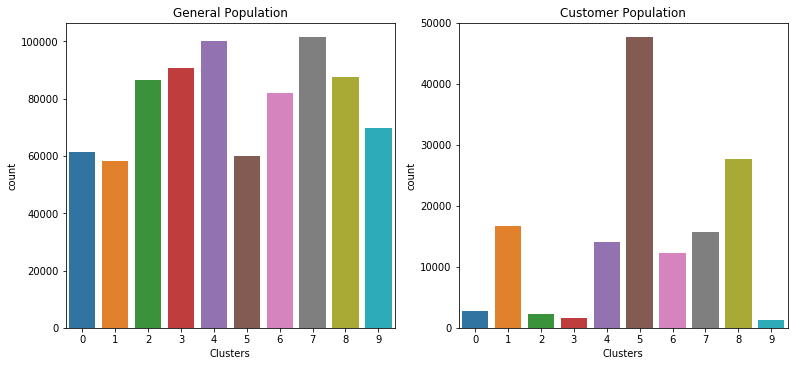

In [135]:
#Proportions WITHOUT MISSING DATA

fig, ax = plt.subplots(1, 2, figsize = (11,5))
sns.countplot(azdias_pred, ax= ax[0])
sns.countplot(customer_pred, ax = ax[1])
ax[0].set_xlabel('Clusters')
ax[1].set_xlabel('Clusters')
ax[0].set_title('General Population')
ax[1].set_title('Customer Population')

plt.tight_layout(pad=0.4, w_pad=0.8, h_pad=1.0)


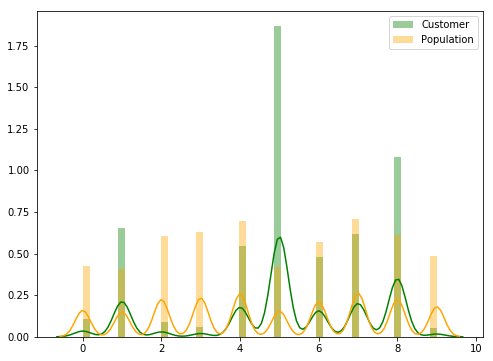

In [136]:
fig = plt.figure(figsize = (8,6))
sns.distplot(customer_pred, label = 'Customer', color = 'green')
sns.distplot(azdias_pred, label = 'Population', color = 'orange')
plt.legend();

In [137]:
pop_predictions = pd.DataFrame(azdias_pred, columns = ['Predictions_Pop'])
cust_predictions = pd.DataFrame(customer_pred, columns = ['Predictions_Cust'])

In [138]:
add_missing_pop = azdias_high_null_count.copy()
add_missing_cust = customer_data_clean_high_null.copy()
add_missing_pop['Label'] = 10
add_missing_cust['Label'] = 10

In [141]:
grouped_pop_predictions = pd.DataFrame(pop_predictions.groupby('Predictions_Pop').size())
grouped_cust_predictions = pd.DataFrame(cust_predictions.groupby('Predictions_Cust').size())

In [143]:
grouped_pop_predictions_final = pd.concat(
    [grouped_pop_predictions, pd.DataFrame(add_missing_pop.groupby(by = 'Label').size())], ignore_index=True)

grouped_cust_predictions_final = pd.concat(
    [grouped_cust_predictions, pd.DataFrame(add_missing_cust.groupby(by = 'Label').size())], ignore_index=True)

In [144]:
grouped_pop_predictions_final.columns = ['Count_Pop']
grouped_cust_predictions_final.columns = ['Count_Cust']

In [150]:
comp_proportions = pd.DataFrame()

In [151]:
comp_proportions['Labels'] = np.arange(0,11)

In [152]:
comp_proportions['Population_prop_per_cluster'] = ((grouped_pop_predictions_final['Count_Pop']/
                                                   (pop_predictions.shape[0]+ add_missing_pop.shape[0])*100).values)
comp_proportions['Customer_prop_per_cluster'] = ((grouped_cust_predictions_final['Count_Cust']/
                                                 (cust_predictions.shape[0]+add_missing_cust.shape[0])*100).values)
comp_proportions['Diff'] = comp_proportions['Customer_prop_per_cluster'] - comp_proportions['Population_prop_per_cluster']

In [154]:
comp_proportions.sort_values(by = ['Diff'], ascending = False)

,Labels,Population_prop_per_cluster,Customer_prop_per_cluster,Diff
5,5,6.744455,24.846597,18.102142
10,10,10.470467,26.054515,15.584049
8,8,9.834373,14.401624,4.567250
1,1,6.530928,8.721015,2.190087
6,6,9.203217,6.355791,-2.847426
7,7,11.382138,8.230021,-3.152116
4,4,11.228865,7.299689,-3.929176
0,0,6.889313,1.402020,-5.487292
9,9,7.832625,0.678835,-7.153791
2,2,9.715099,1.207397,-8.507702


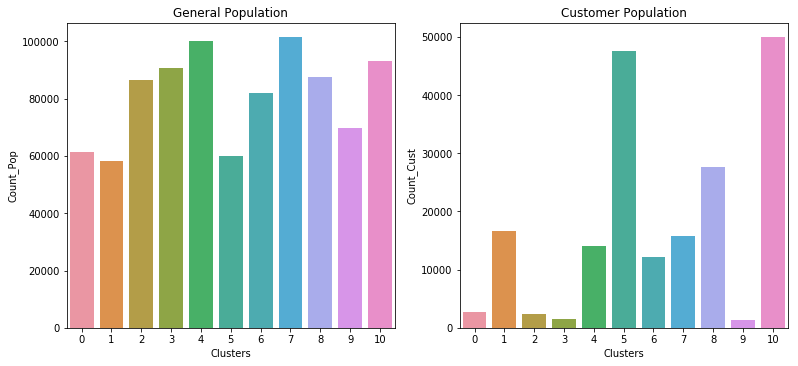

In [159]:
#Proportions with missing values
fig, ax = plt.subplots(1, 2, figsize = (11,5))
sns.barplot(x = np.arange(0,11), y= grouped_pop_predictions_final['Count_Pop'], ax= ax[0])
sns.barplot(x = np.arange(0,11), y = grouped_cust_predictions_final['Count_Cust'], ax = ax[1])
ax[0].set_xlabel('Clusters')
ax[1].set_xlabel('Clusters')
ax[0].set_title('General Population')
ax[1].set_title('Customer Population')

plt.tight_layout(pad=0.4, w_pad=0.8, h_pad=1.0)

In [188]:
def transform_data(pca, X_pca, df, predictions, cluster):
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    X_pca = pd.DataFrame(X_pca, columns = dimensions)
    labels = pd.DataFrame(predictions, columns = ["Prediction"])
    X_pca_labeled = pd.concat([X_pca , labels], axis = 1)
    cluster_df = X_pca_labeled[X_pca_labeled['Prediction'] == cluster].drop(columns='Prediction')
    cluster_transformed = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(cluster_df)))
    cluster_transformed.columns = df.columns
    return cluster_transformed

In [239]:
analysis_cols = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','NATIONALITAET_KZ_1.0',
                 'NATIONALITAET_KZ_2.0','NATIONALITAET_KZ_3.0','OST_WEST_KZ_OW',
                 'FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER',
                 'FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','WEALTH', 'LIFE_STAGE',
                 'SEMIO_SOZ', 'SEMIO_FAM','SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
                 'SEMIO_LUST', 'SEMIO_ERL','SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
                 'SEMIO_DOM', 'SEMIO_KAEM','SEMIO_PFLICHT','SEMIO_TRADV',
                 'ONLINE_AFFINITAET','ANZ_PERSONEN','MOVEMENT','RETOURTYP_BK_S',
                 'SHOPPER_TYP_0.0','SHOPPER_TYP_1.0','SHOPPER_TYP_2.0','SHOPPER_TYP_3.0',
                 'KONSUMNAEHE','BALLRAUM', 'KKK']
over_rep = [5,8,1]

for i in over_rep:
    print('Main features of overrepresented data cluster {}'.format(i))
    transformed_data = transform_data(pca, X_pca_customer, customer_data_clean, customer_pred, i)
    transformed_data = transformed_data[analysis_cols]
    display(transformed_data.mean())

Main features of overrepresented data cluster 5


ALTERSKATEGORIE_GROB     3.486192
ANREDE_KZ                1.052993
NATIONALITAET_KZ_1.0     0.979344
NATIONALITAET_KZ_2.0     0.032321
NATIONALITAET_KZ_3.0    -0.007423
OST_WEST_KZ_OW           0.048164
FINANZ_MINIMALIST        4.989482
FINANZ_SPARER            1.271157
FINANZ_VORSORGER         4.599989
FINANZ_ANLEGER           1.116750
FINANZ_UNAUFFAELLIGER    1.887266
FINANZ_HAUSBAUER         2.080516
WEALTH                   1.966766
LIFE_STAGE               3.612532
SEMIO_SOZ                5.352935
SEMIO_FAM                4.747887
SEMIO_REL                3.527024
SEMIO_MAT                3.763458
SEMIO_VERT               6.419618
SEMIO_LUST               5.717390
SEMIO_ERL                4.237405
SEMIO_KULT               4.736661
SEMIO_RAT                2.466810
SEMIO_KRIT               2.796578
SEMIO_DOM                3.120745
SEMIO_KAEM               2.576655
SEMIO_PFLICHT            2.968240
SEMIO_TRADV              2.936222
ONLINE_AFFINITAET        3.217287
ANZ_PERSONEN  

Main features of overrepresented data cluster 8


ALTERSKATEGORIE_GROB     3.450417
ANREDE_KZ                1.088764
NATIONALITAET_KZ_1.0     0.981029
NATIONALITAET_KZ_2.0     0.022534
NATIONALITAET_KZ_3.0    -0.003342
OST_WEST_KZ_OW           0.078514
FINANZ_MINIMALIST        4.843838
FINANZ_SPARER            1.351190
FINANZ_VORSORGER         4.631007
FINANZ_ANLEGER           1.798371
FINANZ_UNAUFFAELLIGER    1.692709
FINANZ_HAUSBAUER         2.021117
WEALTH                   2.377572
LIFE_STAGE               3.313759
SEMIO_SOZ                4.808246
SEMIO_FAM                4.603393
SEMIO_REL                3.523875
SEMIO_MAT                3.447280
SEMIO_VERT               5.999218
SEMIO_LUST               5.118863
SEMIO_ERL                4.382853
SEMIO_KULT               4.689601
SEMIO_RAT                2.539642
SEMIO_KRIT               3.270524
SEMIO_DOM                2.982295
SEMIO_KAEM               2.586681
SEMIO_PFLICHT            3.134503
SEMIO_TRADV              2.786091
ONLINE_AFFINITAET        2.937705
ANZ_PERSONEN  

Main features of overrepresented data cluster 1


ALTERSKATEGORIE_GROB     3.642252
ANREDE_KZ                1.915849
NATIONALITAET_KZ_1.0     0.946127
NATIONALITAET_KZ_2.0     0.002459
NATIONALITAET_KZ_3.0     0.016449
OST_WEST_KZ_OW           0.059029
FINANZ_MINIMALIST        4.280956
FINANZ_SPARER            1.393576
FINANZ_VORSORGER         4.449622
FINANZ_ANLEGER           1.783951
FINANZ_UNAUFFAELLIGER    2.026324
FINANZ_HAUSBAUER         2.477067
WEALTH                   1.961578
LIFE_STAGE               3.680850
SEMIO_SOZ                2.858222
SEMIO_FAM                1.987749
SEMIO_REL                1.902645
SEMIO_MAT                2.418629
SEMIO_VERT               3.245814
SEMIO_LUST               5.811265
SEMIO_ERL                6.487412
SEMIO_KULT               1.851071
SEMIO_RAT                3.322381
SEMIO_KRIT               5.566348
SEMIO_DOM                5.983728
SEMIO_KAEM               5.725411
SEMIO_PFLICHT            2.704671
SEMIO_TRADV              2.592545
ONLINE_AFFINITAET        3.016906
ANZ_PERSONEN  

In [241]:
under_rep = [3,2,9]

for i in under_rep:
    print('Main features of underrepresented data cluster {}'.format(i))
    transformed_data = transform_data(pca, X_pca_customer, customer_data_clean, customer_pred, i)
    transformed_data = transformed_data[analysis_cols]
    display(transformed_data.mean())

Main features of underrepresented data cluster 3


ALTERSKATEGORIE_GROB     1.910336
ANREDE_KZ                1.989797
NATIONALITAET_KZ_1.0     0.732271
NATIONALITAET_KZ_2.0     0.108740
NATIONALITAET_KZ_3.0     0.078272
OST_WEST_KZ_OW           0.206740
FINANZ_MINIMALIST        1.645995
FINANZ_SPARER            3.652722
FINANZ_VORSORGER         2.762684
FINANZ_ANLEGER           3.515852
FINANZ_UNAUFFAELLIGER    3.188109
FINANZ_HAUSBAUER         3.967866
WEALTH                   4.280077
LIFE_STAGE               2.219404
SEMIO_SOZ                3.273011
SEMIO_FAM                3.720709
SEMIO_REL                4.912893
SEMIO_MAT                4.732004
SEMIO_VERT               2.334545
SEMIO_LUST               3.174817
SEMIO_ERL                4.536968
SEMIO_KULT               3.874003
SEMIO_RAT                5.894712
SEMIO_KRIT               5.587078
SEMIO_DOM                6.339415
SEMIO_KAEM               6.236549
SEMIO_PFLICHT            5.835481
SEMIO_TRADV              5.353297
ONLINE_AFFINITAET        2.851039
ANZ_PERSONEN  

Main features of underrepresented data cluster 2


ALTERSKATEGORIE_GROB     2.048439
ANREDE_KZ                1.943678
NATIONALITAET_KZ_1.0     0.800069
NATIONALITAET_KZ_2.0     0.072484
NATIONALITAET_KZ_3.0     0.074033
OST_WEST_KZ_OW           0.090559
FINANZ_MINIMALIST        2.891863
FINANZ_SPARER            3.435624
FINANZ_VORSORGER         2.705411
FINANZ_ANLEGER           3.959797
FINANZ_UNAUFFAELLIGER    3.525374
FINANZ_HAUSBAUER         2.369117
WEALTH                   2.452109
LIFE_STAGE               3.197832
SEMIO_SOZ                2.915824
SEMIO_FAM                3.476499
SEMIO_REL                4.654359
SEMIO_MAT                4.646994
SEMIO_VERT               2.853498
SEMIO_LUST               3.205148
SEMIO_ERL                4.660032
SEMIO_KULT               3.761826
SEMIO_RAT                5.701398
SEMIO_KRIT               5.385336
SEMIO_DOM                5.879922
SEMIO_KAEM               5.580227
SEMIO_PFLICHT            5.506376
SEMIO_TRADV              5.232132
ONLINE_AFFINITAET        3.875991
ANZ_PERSONEN  

Main features of underrepresented data cluster 9


ALTERSKATEGORIE_GROB     2.140270
ANREDE_KZ                0.972634
NATIONALITAET_KZ_1.0     0.813204
NATIONALITAET_KZ_2.0     0.130303
NATIONALITAET_KZ_3.0     0.023513
OST_WEST_KZ_OW           0.267675
FINANZ_MINIMALIST        2.290300
FINANZ_SPARER            3.919584
FINANZ_VORSORGER         2.423944
FINANZ_ANLEGER           3.028467
FINANZ_UNAUFFAELLIGER    3.523917
FINANZ_HAUSBAUER         3.322299
WEALTH                   4.294844
LIFE_STAGE               2.013203
SEMIO_SOZ                6.253799
SEMIO_FAM                6.420278
SEMIO_REL                5.712825
SEMIO_MAT                4.958638
SEMIO_VERT               6.048669
SEMIO_LUST               3.482786
SEMIO_ERL                2.619793
SEMIO_KULT               6.414599
SEMIO_RAT                3.842742
SEMIO_KRIT               3.051230
SEMIO_DOM                3.113371
SEMIO_KAEM               2.657538
SEMIO_PFLICHT            5.099280
SEMIO_TRADV              4.537004
ONLINE_AFFINITAET        3.344750
ANZ_PERSONEN  

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
**ANSWER:**

|FEATURE|DESCRIPTION|OVER_REP_CLUSTER_5|UNDER_REP_CLUSTER_3|
|---|---|---|---|
|ALTERSKATEGORIE_GROB| Estimated age based on given name analysis|46 - 60 years old|30 - 45 years old|
|ANREDE_KZ| Gender|male|female|
|NATIONALITAET_KZ|Nationality based on given name analysis|German-sounding|foreign-sounding|
|OST_WEST_KZ|Building location via former East / West Germany (GDR / FRG)|West|West|
|FINANZ*|Financial typology|investor, money-saver|low financial interest|
|WEALTH|Life Stage Typology - Wealth|Prosperous Households|Less Affluent|
|LIFE_STAGE|Life Stage Typology - Lifestyle|Families With School Age Children|Young Couples With Children|
|SEMIO*|Personality typology|very high affinity to rational, combative attitude|very high affinity to being dreamful|
|ONLINE_AFFINITAET|Online affinity|high|high|
|ANZ_PERSONEN|Number of adults in household|about 3|about 2|
|MOVEMENT|Dominating movement (mainstream/avantgarde)|Avantgarde|Mainstream|
|RETOURTYP_BK_S| Return type|conservative Low-Returner|incentive-receptive Normal-Returner|
|SHOPPER_TYP| Shopper typology|family-shopper, but all others too|external supplied hedonists, but all others too|
|KONSUMNAEHE|Distance from building to point of sale (PoS)|building is located in a 500 x 500m grid cell that includes at least one RA1-consumption cell|building is located in a 250 x 250m grid cell that includes at least one RA1-consumption cell|
|BALLRAUM|Distance to nearest urban center|30 -  40 km|20 -  30 km|
|KKK|Purchasing power in region|high|average-high|

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.